In [15]:
# from graph_tool import *
# import graph_tool.all as gt
from igraph import *
import pickle
import numpy as np
from collections import Counter, defaultdict
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing
from scipy.optimize import minimize
%matplotlib inline

In [2]:
# user_ = pickle.load(open("../data/user_edges.p", 'rb' ))
# business_ = pickle.load(open("../data/business_edges.p", 'rb' ))
review_ = pickle.load(open("../data/review_edges.p", 'rb' ))
# cruis_ = pickle.load(open("../data/cruis_edges.p", 'rb' ))

dict_all_users_of_a_business = pickle.load(open("../data/dict_all_users_of_a_business.p", 'rb'  ))
dict_all_businesses_of_a_user = pickle.load(open("../data/dict_all_businesses_of_a_user.p", 'rb'  ))

In [3]:
g = gt.Graph(directed=False)
vuprop = g.new_vertex_property("string") # prop for user
vbprop = g.new_vertex_property("string") # prop for business
vcprop = g.new_vertex_property("vector<string>") # prop for cruisine
erprop = g.new_edge_property('int16_t') # prop for rating
euuprop = g.new_edge_property("vector<string>") # prop for user-user
ebbprop = g.new_edge_property("vector<string>") # prop for business-business
eubprop = g.new_edge_property("vector<string>") # prop for user-business
# ecprop = g.new_edge_property("vector<string>") # prop for business-business by same cruisine

In [4]:
start = time.time()
# Create dictionaries to store the vertex node objects
users_vertex = defaultdict()
businesses_vertex = defaultdict()
# Create dictionaries to store the edge node objects
user_edges = defaultdict()
business_edges = defaultdict()
review_edges = defaultdict()
cruis_edges = defaultdict()

for user, business, rating, cruisine in review_:  
#     print user, business, rating, cruisine
    if user not in users_vertex:
        vu = g.add_vertex() # vertex of user
        users_vertex[user] = vu
        g.vertex_properties['user_id'] = vuprop
        g.vertex_properties['user_id'][vu] = user.encode("utf-8")

    if business not in businesses_vertex:
        vb = g.add_vertex() # vertex of business
        businesses_vertex[business] = vb
        g.vertex_properties['business_id'] = vbprop
        g.vertex_properties['business_id'][vb] = business.encode("utf-8")
        g.vertex_properties['cruisine'] = vcprop
        g.vertex_properties['cruisine'][vb] = cruisine

    if (user, business) not in review_edges:
        er = g.add_edge(vu,vb) # edge of review (USER,BUSINESS)
        review_edges[(user, business)] = er
        g.edge_properties['rating'] = erprop
        g.edge_properties['rating'][er] = rating
        g.edge_properties['review_id'] = eubprop
        g.edge_properties['review_id'][er] = (user.encode("utf-8"), business.encode("utf-8"))

# for user1, user2 in user_:
#     if (user1, user2) not in user_edges:
#         euu = g.add_edge(users_vertex[user1], users_vertex[user2])
#         user_edges[(user1, user2)] = euu
#         g.edge_properties['user_user_id'] = euuprop
#         g.edge_properties['user_user_id'][euu] = (user1.encode("utf-8"), user2.encode("utf-8"))

# for bus1, bus2 in business_:
#     if (bus1, bus2) not in business_edges:
#         ebb = g.add_edge(businesses_vertex[bus1], businesses_vertex[bus2])
#         business_edges[(bus1, bus2)] = ebb
#         g.edge_properties['bus_bus_id'] = ebbprop
#         g.edge_properties['bus_bus_id'][ebb] = (bus1.encode("utf-8"), bus2.encode("utf-8"))
        
# for b1, b2 in cruisine_:
#     if (b1, b2) not in cruis_edges:
#         ec = g.add_edge(businesses_vertex[b1], businesses_vertex[b2])
#         cruis_edges[(b1, b2)] = ec
#         g.edge_properties['cruisine_cat'] = ecprop
#         g.edge_properties['cruisine_cat'][ec] = (b1.encode("utf-8"), b2.encode("utf-8"))

end = time.time()
print "Took %f seconds" %(end - start)

Took 35.646746 seconds


In [69]:
print 'Edges: %d' %g.num_edges()
print 'Vertices: %d' %g.num_vertices()
print g.list_properties()

Edges: 108399
Vertices: 17756
business_id    (vertex)  (type: string)
cruisine       (vertex)  (type: vector<string>)
user_id        (vertex)  (type: string)
rating         (edge)    (type: int16_t)
review_id      (edge)    (type: vector<string>)
None


In [6]:
print 'Edges: %d' %g.num_edges()
print 'Vertices: %d' %g.num_vertices()
print g.list_properties()

Edges: 11286985
Vertices: 17756
business_id    (vertex)  (type: string)
cruisine       (vertex)  (type: vector<string>)
user_id        (vertex)  (type: string)
bus_bus_id     (edge)    (type: vector<string>)
rating         (edge)    (type: int16_t)
review_id      (edge)    (type: vector<string>)
user_user_id   (edge)    (type: vector<string>)
None


In [7]:
# Test a couple vertices. There are 2 types of vertices (1.User 2. Business)
print g.vertex_properties['user_id'][g.vertex(0)]
print g.vertex_properties['business_id'][g.vertex(1)]
print g.vertex_properties['cruisine'][g.vertex(1)]

/user_details?userid=v8cFU4eJKgVgGYCyovE3kQ
pho-huynh-hiep-2-kevins-noodle-house-san-francisco
['Vietnamese', 'vietnamese']


In [8]:
# Test a couple edges
print g.edge_properties['review_id'][g.edge(0,1)]
print g.edge_properties['rating'][g.edge(0,1)]

['/user_details?userid=v8cFU4eJKgVgGYCyovE3kQ', 'pho-huynh-hiep-2-kevins-noodle-house-san-francisco']
4


# Community

In [5]:
gt.graph_draw(g)

(<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x10875da50, at 0x121c7d6d0>,
 <PropertyMap object with key type 'Vertex' and value type 'bool', for Graph 0x10875da50, at 0x11d5023d0>)

In [73]:
def compute_modularity(g, iters, spins):
    b = gt.community_structure(g, iters, spins)
    mod = gt.modularity(g, b)
    return b, mod

In [83]:
b = gt.community_structure(g, 100, 10, weight=g.edge_properties['rating'])
print "Original Modularity: ", gt.modularity(g, gt.label_components(g)[0])
print "Original Num Components: ", len(np.unique(gt.label_components(g)[1]))
print "Computed Modularity: ", gt.modularity(g, b)
print "Computed Num Components: ", len(np.unique(b.a))

Original Modularity:  0.53777505541
Original Num Components:  88
Computed Modularity:  0.784132441231
Computed Num Components:  10


In [5]:
def optimize_modularity(x):
    b = gt.community_structure(g, 100, x)
    return -1*(gt.modularity(g, b))

In [28]:
r = []
for i in xrange(3):
    r.append(minimize(optimize_modularity, 0, method='COBYLA', options={'disp': True}).x)
np.mean(r)

AttributeError: 'list' object has no attribute 'x'

In [30]:
b = gt.community_structure(g, 100, np.mean(r))
gt.modularity(g, b)

0.6998205140765744

In [14]:
def optimize_nogroups(g):
    nstart = 0
    nend = 30
    mod_list = []
    for i in xrange(nstart, nend, 2):
        b = gt.community_structure(g, 100, i)
        mod_list.append(gt.modularity(g, b))

    # Plot of no groups
    print xrange(nstart,nend, 2)[np.argmax(mod_list)]
    plt.plot(xrange(nstart,nend, 2), mod_list)

18


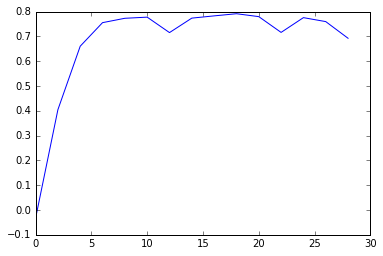

In [15]:
optimize_nogroups(g)

In [368]:
def optimize_noiterations(g):
    nstart = 0
    nend = 100
    mod_list = []
    for i in xrange(nstart, nend, 2):
        b = gt.community_structure(g, i, 10)
        mod_list.append(gt.modularity(g, b))

    # Plot of no iterations
    plt.plot(xrange(nstart,nend, 2), mod_list)

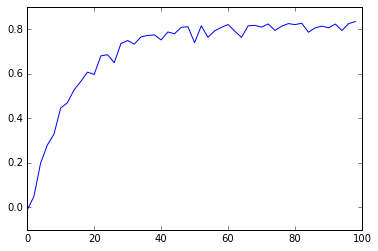

In [369]:
optimize_noiterations(g)

### Try an example

In [14]:
pd.value_counts(b.a)

7    2771
1    1886
5    1845
6    1799
3    1721
2    1675
4    1639
0    1549
9    1507
8    1364
dtype: int64

In [11]:
community_group = b.a[int(businesses_vertex['z-and-y-restaurant-san-francisco-3'])]
community_group

4

In [26]:
g.vertex_properties['business_id'][businesses['z-and-y-restaurant-san-francisco-3']]

'z-and-y-restaurant-san-francisco-3'

# Block Model

In [257]:
g.edge_properties['rating']

<PropertyMap object with key type 'Edge' and value type 'int16_t', for Graph 0x131221290, at 0x1311c8a50>

In [54]:
state = gt.minimize_blockmodel_dl(g, eweight= g.edge_properties['rating'], verbose=True)
b = state.b
# gt.graph_draw(g, vertex_fill_color=b, vertex_shape=b)

max_B: 242
(shrinking from B=17756 to B=242)
Shrinking: 17756 -> 8878
merging, B=12546 left: 3668 (17828.2, 5210)
merging, B=10197 left: 1319 (-2.44724e-11, 2349)
merging, B=9255 left: 377 (-2.7464e-11, 942)
merging, B=8929 left: 51 (-2.85605e-11, 326)
merging, B=8890 left: 12 (-2.17568e-11, 39)
merging, B=8878 left: 0 (-1.72804e-11, 12)
Performing sweeps for beta = ∞, B=17756 (N=17756)...
... performed 20 sweeps with 0 vertex moves (dS = 0)
Minimizing for: 8878
Performing sweeps for beta = ∞, B=8878 (N=17756)...
... performed 30 sweeps with 14200 vertex moves (dS = -28264.4)
Shrinking: 8878 -> 4439
merging, B=7282 left: 2843 (6107.76, 1596)
merging, B=6327 left: 1888 (-1.19316e-11, 955)
merging, B=5686 left: 1247 (-2.38454e-11, 641)
merging, B=5222 left: 783 (-1.73312e-11, 464)
merging, B=4935 left: 496 (-2.64222e-11, 287)
merging, B=4732 left: 293 (-1.32756e-11, 203)
merging, B=4597 left: 158 (-1.40536e-11, 135)
merging, B=4509 left: 70 (-2.29516e-11, 88)
merging, B=4451 left: 12 (-1

In [55]:
print gt.modularity(g, b)
b

-0.151228940517


<PropertyMap object with key type 'Vertex' and value type 'int32_t', for Graph 0x10875da50, at 0x11daf2bd0>

### Assign the model's component (group) property to our network G graph

In [56]:
g.vertex_properties['components'] = b

In [57]:
len(np.unique(g.vertex_properties['components'].a))

73

In [354]:
u = gt.GraphView(g, vfilt=lambda x: g.vertex_properties['components'][x] == 4)
u
state = gt.minimize_blockmodel_dl(u, eweight= u.edge_properties['rating'])
b = state.b
gt.modularity(u, b)

ValueError: The lower bound exceeds the upper bound.

In [325]:
b.a

PropertyArray([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [61]:
state1 = gt.minimize_nested_blockmodel_dl(g)
gt.modularity(g, state1.clabel)
# gt.draw_hierarchy(state1)

0.0

In [7]:
state = gt.minimize_blockmodel_dl(u)
b = state.b
gt.graph_draw(u, vertex_fill_color=b, vertex_shape=b)

(<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x10d3af710, at 0x118a7a9d0>,
 <PropertyMap object with key type 'Vertex' and value type 'bool', for Graph 0x10d3af710, at 0x10cf7d790>)

# TESTS

In [205]:
# vprop = g.new_vertex_property("string")
# g.vertex_properties['user_id'] = vprop
# g.vertex_properties['user_id'][g.vertex(0)] = 'hello'
# g.vertex_properties['business_id'] = vprop
# g.vertex_properties['business_id'][g.vertex(0)] = 'bye'

eprop = g.new_edge_property('string')
g.edge_properties['rating'] = eprop
g.edge_properties['rating'][g.edge(0,1)] = 'hello'

In [244]:
eprop = g.new_edge_property('string')

In [267]:
vprop = g.new_vertex_property('int16_t')
g.vertex_properties['integer'] = vprop
g.vertex_properties['integer'][g.vertex(10)] = 1

ValueError: Invalid vertex index: 10

In [9]:
g = gt.Graph(directed=False)
g.add_vertex(10)

<generator object <genexpr> at 0x123d85960>

In [10]:
g.add_edge(0,1)
g.add_edge(1,2)
g.add_edge(2,3)
g.add_edge(3,4)
g.add_edge(4,5)

<Edge object with source '4' and target '5' at 0x1266d7df8>

In [126]:
vb, eb = gt.betweenness(g)

In [131]:
init_list = list(g.edges())
max_edge_list = np.argsort(eb.a)[:-1][0:2]
print max_edge_list
for i in max_edge_list:
    g.remove_edge(init_list[i])

[0 4]


In [134]:
list(g.edges())
g.num_edges()

3

In [130]:
np.argsort(eb.a)[:-1][0:2]

PropertyArray([0, 4])

In [83]:
for i in max_edge_index:
    print list(g.edges())[i]

(0, 1)
(4, 5)


In [12]:
prop = g.new_edge_property("vector<string>")
g.edge_properties['user_bus'] = prop
g.edge_properties['user_bus'][g.edge(0,1)] = ['hello','joe']
g.edge_properties['user_bus'][g.edge(1,2)] = ['bye','joe']
g.edge_properties['user_bus'][g.edge(2,3)] = ['hi','allen']
g.edge_properties['user_bus'][g.edge(3,4)] = ['hi','lee']
g.edge_properties['user_bus'][g.edge(4,5)] = ['hi','john']
vprop = g.new_vertex_property('string')
g.vertex_properties['user'] = vprop
g.vertex_properties['user'][g.vertex(1)] = 'joe'
g.vertex_properties['user'][g.vertex(2)] = 'john'
g.vertex_properties['user'][g.vertex(3)] = 'allen'

In [14]:
g.vertex_properties['user'][g.vertex(1)]

'joe'

In [15]:
for i,j in g.edges():
    print i,j
    print g.edge_properties['user_bus'][g.edge(i,j)]

0 1
['hello', 'joe']
1 2
['bye', 'joe']
2 3
['hi', 'allen']
3 4
['hi', 'lee']
4 5
['hi', 'john']


In [63]:
u = gt.GraphView(g, efilt=lambda x: g.edge_properties['user_bus'][x][-1] == 'joe', vfilt=lambda x: x in [0,1,2])
# u = gt.GraphView(g, efilt=lambda x: x in list(g.edges()), vfilt=lambda x: x in list(g.vertices()))
# u = gt.GraphView(g, efilt=lambda x: x in list(g.edges()), vfilt=lambda x: x in [0,1] or x in [0])

In [64]:
list(u.edges())

[<Edge object with source '0' and target '1' at 0x11945c218>,
 <Edge object with source '1' and target '2' at 0x11945c2b0>]

In [65]:
list(u.vertices())

[<Vertex object with index '0' at 0x119445750>,
 <Vertex object with index '1' at 0x1194456d0>,
 <Vertex object with index '2' at 0x1194571d0>]

In [ ]:
u = GraphView(g, vfilt=lambda x: g.edge_properties['test'][x] == 'hello')

In [ ]:
(g.edge_properties['user_bus'][x]).split(",") == 'joe'

In [412]:
for i in u.edges():
    print i

(0, 1)
(1, 2)
(2, 3)


In [327]:
for i in g.edges():
    print i

(1, 2)
(2, 1)


In [168]:
g = gt.collection.data["polbooks"]
state = gt.minimize_blockmodel_dl(g)
b = state.b
gt.graph_draw(g, vertex_fill_color=b, vertex_shape=b)

(<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x11bf18b90, at 0x11bf69550>,
 <PropertyMap object with key type 'Vertex' and value type 'bool', for Graph 0x11bf18b90, at 0x11bf12b90>)

In [138]:
print g.num_edges()
print g.num_vertices()

441
105


In [145]:
g.list_properties()

description    (graph)   (type: string, val: Books about US politics: A network
                                             of books about US politics
                                             published around the time of the
                                             2004 presidential election and sold
                                             by the online bookseller
                                             Amazon.com. Edges between books
                                             represent frequent copurchasing of
                                             books by the same buyers. The
                                             network was compiled by V. Krebs
                                             and is unpublished, but can found
                                             on Krebs' `web site
                                             <http://www.orgnet.com/>`_.
                                             Retrieved from `Mark Newman's
                 

In [166]:
g.vertex_properties.pos[g.vertex(1)]

array([-146.8949707 ,   47.89453442])

In [169]:
g = gt.price_network(3000)

In [172]:
g = gt.random_graph(1000, lambda: (5,5))

In [175]:
g.num_vertices()

1000

In [180]:
import itertools
a =[[1,1,1] ,[1,1,2,["Afghan","afghani"],["Middle Eastern","mideastern"]]]

In [181]:
list(itertools.chain(*a))

[1, 1, 1, 1, 1, 2, ['Afghan', 'afghani'], ['Middle Eastern', 'mideastern']]

In [393]:
len(master)

108399

In [8]:
import numpy as np
import pandas as pd

In [3]:
group = []
for i in master:
    cat = i[-1]
    group.append(cat)
#     break

In [4]:
len(group)

108399

In [5]:
len(np.unique(np.array(group)))

351

In [9]:
pd.value_counts(np.array(group))

[Mexican, mexican]                                                                               4569
[Japanese, japanese, Sushi Bars, sushi]                                                          3718
[American (New), newamerican]                                                                    3696
[Asian Fusion, asianfusion]                                                                      3423
[Italian, italian]                                                                               3262
[Pizza, pizza]                                                                                   3205
[Thai, thai]                                                                                     2775
[Italian, italian, Pizza, pizza]                                                                 2331
[Seafood, seafood]                                                                               1971
[Vietnamese, vietnamese]                                                          

# Create MSE #1 - Baseline to Beat

In [8]:
# Create unique businesses and users so we can count how many rows and columns we needs
# users_set = set()
# businesses_set = set()
# for i in master:
#     users_set.add(i[0]) 
#     businesses_set.add(i[1])
# users_list = list(users_set)
# businesses_list = list(businesses_set)
users = dict_all_businesses_of_a_user.keys()
businesses = dict_all_users_of_a_business.keys()

In [9]:
# Create user and business dictionaries so we can keep track of the indicies when filling in matrix
users_dic = defaultdict(int)
businesses_dic = defaultdict(int)
for i,j in enumerate(users):
    users_dic[j] = i
for i,j in enumerate(businesses):
    businesses_dic[j] = i

In [32]:
# Create matrix of reviews, sparse matrix
num_users = len(users)
num_businesses = len(businesses)
# Create empty matrix
mat = np.zeros((num_users, num_businesses))
# Iterate each user-business combo and insert the actual review value
for user, bus, rating, cruisine in review_[0:10]:
    mat[users_dic[user], businesses_dic[bus]] = rating
# Compute the average restaurant review based on all users who reviewed each restaurant, which we use later to compute MSE
avg_restaurant_rating = np.sum(mat, axis=0) / np.sum(mat!=0, axis=0)

mse1 = []
# Iterate each restaurant column to compute MSE but ONLY for reviews where there are values
for i in xrange(num_businesses):
    # take only non-zero column values 
    mask = mat[:,i] != 0
    base_vector = mat[:,i][mask]
    # compute the number of users who actually reviewed that restaurant
    col_len = sum(mask)
    # create a new vector for average restaurant ratings of length previously computed
    average_vector = np.zeros(col_len)
    # fill in this vector with constant value
    average_vector.fill(avg_restaurant_rating[i])
    # take different of vectors and square difference to get MSE
    mse = np.sum((base_vector - average_vector) ** 2)
    # Append this mse for this restaurant ONLY
    mse1.append(mse)
#     break
mse1 = np.array(mse1)
print np.mean(mse1[mse1!=0])

6.9


In [79]:
print mat.shape
print avg_restaurant_rating

(16954, 802)
[ 3.71428571  3.60588235  4.16393443  3.24358974  3.70212766  3.45283019
  4.13733906  3.79545455  3.67924528  3.89010989  3.8245614   3.69444444
  3.63076923  3.58947368  3.75103734  3.81333333  3.94413408  3.97560976
  3.46202532  3.45762712  4.18518519  3.38461538  3.64646465  3.7311828
  3.95        4.43442623  4.04878049  4.20155039  4.16374269  3.8411215
  3.79141104  3.42222222  4.1512605   3.60714286  3.7012987   4.10416667
  4.25619835  3.90163934  4.29139073  3.9047619   4.16666667  4.15083799
  3.32758621  4.32323232  3.71631206  3.17857143  3.48148148  3.24489796
  4.05        4.08955224  4.09333333  3.84        4.16326531  3.79310345
  3.9         3.74509804  3.21794872  3.45882353  3.5862069   3.54411765
  4.01627219  3.82386364  3.82666667  3.34065934  3.43165468  4.06666667
  3.45283019  3.94666667  3.97560976  3.37735849  4.04587156  3.8630137
  3.13333333  3.31428571  3.23728814  4.0703125   4.08080808  3.97326203
  4.33333333  3.51592357  3.83870968  3.8

# Create MSE #2 - My Adjusted Rating

In [13]:
# This should be assigned to the master network but we need to iterate through different 
g.vertex_properties['components'] = b
business = 'so-san-francisco-4'
g.vertex_properties['components'][businesses_vertex[business]]

3

In [448]:
for user, bus, rating, cruisine in review_[0:500]:
    print user, bus
    break
print users_vertex[user]
print businesses_vertex[bus]

/user_details?userid=v8cFU4eJKgVgGYCyovE3kQ pho-huynh-hiep-2-kevins-noodle-house-san-francisco
9877
9878


In [449]:
g.edge_properties['rating'][g.edge(9877,9878)]

4

In [22]:
# g.vertex_properties['business_id'][27634]
# g.edge(0, 27634)
# for u in u.vertices():
#     print u

# bus_vertex

<Vertex object with index '17001' at 0x1210137d0>

### First need to prove that clustering communties gives better score

In [33]:
user_community_vertices = defaultdict()
mat_community = np.zeros((num_users, num_businesses))
for user, bus, rating, cruisine in review_[0:10]:
    comm = g.vertex_properties['components'][users_vertex[user]]
    if user not in user_community_vertices:
        u = gt.GraphView(g, vfilt=lambda x: g.vertex_properties['components'][x] == comm and 
                                        len(g.vertex_properties['user_id'][x]) > 0)    
        user_community_vertices[user] = u.vertices()
    # need users vertex only which are in this community
    # then find the respective user-bus for each eacher within the community
    bus_vertex = businesses_vertex[bus]
    rate = []
    for i in user_community_vertices[user]:
        try:
#             print i, bus_vertex
            rating = g.edge_properties['rating'][g.edge(i, bus_vertex)]
            rate.append(rating)
        except:
            continue
            
    mat_community[users_dic[user], businesses_dic[bus]] = np.mean(rate)
    
mse2 = []       
for i in xrange(num_businesses): 
    mask = mat[:,i] != 0
    base_vector = mat[:,i][mask]
    mask = mat_community[:,i] != 0
    community_vector = mat_community[:,i][mask]
    
    mse = np.sum((base_vector - community_vector) ** 2)
    mse2.append(mse)  
mse2 = np.array(mse2)
print np.mean(mse2[mse2!=0])

7.06198347107


In [27]:
mse2 = np.array(mse2)
# print np.mean(mse2[mse2!=0])

In [253]:
# multipy each weight by the user rating
mat_weights = np.zeros((num_users, num_businesses))
# Create user-business weights ONLY where we have reviews
count = 0
for user, bus, rating, cruisine in review_[0:500]:
    count +=1
    # Compute the weight for every review
    weight = rescale_value(compute_modularity(user, bus))
    mat_weights[users_dic[user], businesses_dic[bus]] = weight
    print count, weight


1 0.610610227521
2 0.610667588523
3 0.631454855404
4 0.584966009855
5 0.599794770108
6 0.613439552041
7 0.599102937994
8 0.636168013949
9 0.616739514524
10 0.637851104574
11 0.617503718426
12 0.602621928833
13 0.609501366865
14 0.607917903384
15 0.603794501119
16 0.599327990141
17 0.617586485597
18 0.613786294741
19 0.559284737924
20 0.646784891017
21 0.62959975489
22 0.629650202662
23 0.610405294438
24 0.588102069123
25 0.636791804322
26 0.615028675477
27 0.632997936914
28 0.603000823535
29 0.646565160209
30 0.619165004105
31 0.590454530635
32 0.639975241335
33 0.585435659448
34 0.624683415676
35 0.628673448036
36 0.622957504034
37 0.602532757312
38 0.591893887384
39 0.595874100492
40 0.602986131207
41 0.556601381606
42 0.632938690974
43 0.616611158684
44 0.610385735504
45 0.640257513972
46 0.642377114121
47 0.658025869686
48 0.617434800822
49 0.665204832577
50 0.66454435361
51 0.650885276355
52 0.668324961054
53 0.613940986898
54 0.599528527019
55 0.612215598023
56 0.689091469615
57 

In [257]:
# Can move this up to mse1 function to compute together!
mse2 = []
for i in xrange(num_businesses): 
    mask = mat[:,i] != 0
    base_vector = mat[:,i][mask]
    mask = mat_weights[:,i] != 0
    weights_vector = mat_weights[:,i][mask]
    total_weight = np.sum(weights_vector)
    # multiply the original matrix by our weights matrix and divide by the sum of weights per restaurant
    temp = (base_vector * weights_vector) / total_weight
    #     temp = (mat * mat_weights) / mat_weights.sum(axis=0)
    # Rescale the matrix rating to 1-5 after re-weighting
#     mat_scaled = np.apply_along_axis(rescale, 0, temp)
    if np.any(temp):
        model_vector = rescale_column(temp)
    else:
        model_vector = temp
    mse = np.sum((base_vector - model_vector) ** 2)
    mse2.append(mse)

    
# Take squared difference of original matrix and my scaled matrix, then average by restaurant
# temp = np.mean((mat - mat_scaled) **2, axis=0)
# Finally, take the average mean square error across all restaurants
# ms2 = np.mean(temp)
print np.mean(mse2)

# How do the 2 MSE compare? Have we improved recommended rating of a restaurant of any new reviewer?
# Compare models: the better model will have a large difference between the 2 MSEs with my MSE being lower since the
# standard MSE will never change. 
# Then we could predict reviews for a newcomer to a particular restaurant based on their relationship to communities. 

0.155106842093


In [225]:
np.sum(mat!=0)

100

In [210]:
print mat[mat[:,0]!=0].shape
print mat_weights[mat_weights[:,0]!=0].shape

(0, 802)
(0, 802)


In [197]:
np.sum((mat_weights.sum(axis=0))!=0)

3

In [164]:
def gather_user_verticies(user):
    # Gather up all verticies related to this restaurant 
    # The first vertex is the restaurant itself
#     vertex_list = [businesses_vertex[business]] 
    # Append all users of this business[business]
#     users = dict_all_users_of_a_business[business]
    # Append all businesses of each user of this business
    vertex_list = [users_vertex[user]]
#     for user in users:
#     vertex_list.append(users[user])
    businesses = dict_all_businesses_of_a_user[user]
    for business in businesses:
        vertex_list.append(businesses_vertex[business])
    return vertex_list

In [139]:
user_vertex_list = gather_user_verticies("/user_details?userid=vkcbILTGGd1ejg5xSmAHeQ")
print '\n', g.vertex_properties['business_id'][7796]
print len(user_vertex_list)

sauce-san-francisco
playground-san-francisco
seniores-pizza-san-francisco
yojimbo-alameda
little-star-pizza-san-francisco
san-tung-chinese-restaurant-san-francisco
yoshis-oakland-oakland
pho-huynh-hiep-2-kevins-noodle-house-san-francisco
fentons-creamery-oakland-2
shooting-star-cafe-oakland
kowloon-tong-dessert-cafe-san-francisco
geta-oakland
volcano-san-francisco
champa-garden-oakland
el-farolito-san-francisco-2
hang-ten-boiler-alameda
homeroom-oakland
ohgane-korean-restaurant-oakland
sushirrito-san-francisco-4

sauce-san-francisco
20


In [149]:
u = gt.GraphView(g, vfilt=lambda x: g.vertex_properties['components'][x] == 9 or x in user_vertex_list)  #   

In [156]:
for i in list(u.vertices()):
    print u.vertex_properties['components'][i]

9

In [165]:
def compute_modularity(user, bus):
    # Create filtered network including only the cluster which restaurant belongs and the restaurant's network
    # User provides a business and I take my master network and filter based on the community which the restaurant 
    # belongs to AND on the user-business network.
    group = g.vertex_properties['components'][businesses_vertex[bus]]
    user_vertex_list = gather_user_verticies(user)
    u = gt.GraphView(g, vfilt=lambda x: g.vertex_properties['components'][x] == group or
                                        x in user_vertex_list)
    state = gt.minimize_blockmodel_dl(u, eweight= u.edge_properties['rating'])
    b = state.b
    modularity = gt.modularity(u, b)
    return modularity

In [168]:
print compute_modularity("/user_details?userid=vkcbILTGGd1ejg5xSmAHeQ", "sauce-san-francisco")
print compute_modularity("/user_details?userid=vkcbILTGGd1ejg5xSmAHeQ", "kowloon-tong-dessert-cafe-san-francisco")

0.228655835946
0.599430748436


In [ ]:
# compute the weighted average

In [57]:
a = np.array([[2,0,2,2], [1,2,1,0], [1,1,2,0]])
b = np.array([[0.5,0.5,0.5,0.5],[0.5,0.5,0.5,0.5],[0.5,0.5,0.5,0.5]])
a

array([[2, 0, 2, 2],
       [1, 2, 1, 0],
       [1, 1, 2, 0]])

In [59]:
(a - b) **2

array([[ 2.25,  0.25,  2.25,  2.25],
       [ 0.25,  2.25,  0.25,  0.25],
       [ 0.25,  0.25,  2.25,  0.25]])

In [55]:
scaled = (a * b) / b.sum(axis=0)
np.apply_along_axis(rescale, 0, scaled)

array([[ 5.,  5.,  5.,  5.],
       [ 1.,  5.,  1.,  1.],
       [ 1.,  1.,  5.,  1.]])

In [183]:
def rescale_column(column):
    OldMax = np.max(column)
    OldMin = np.min(column)
    NewMax = 5.0
    NewMin = 1.0
    OldRange = (OldMax - OldMin)  
    NewRange = (NewMax - NewMin)
    NewValues = map(lambda x: (((x - OldMin) * NewRange) / OldRange) + NewMin, column)
    return NewValues
def rescale_value(value):
    OldMax = 1.0
    OldMin = -1.0
    NewMax = 1.0
    NewMin = 0.0
    OldRange = (OldMax - OldMin)  
    NewRange = (NewMax - NewMin)
    NewValue = (((value - OldMin) * NewRange) / OldRange) + NewMin
    return NewValue

In [52]:
rescale([ 0.33333333,  0.66666667,  0.33333333,  0.33333333])

0.33333333 4.0 0.33333334 1.0
[0.33333333, 0.66666667, 0.33333333, 0.33333333]


[1.0, 5.0, 1.0, 1.0]

In [24]:
np.max(np.array([ 0.33333333,  0.33333333,  0.33333333,  0.33333333]))

0.33333332999999998

In [ ]:
map(lambda x: (((x - OldMin) * NewRange) / OldRange) + NewMin, column)

In [40]:
a = np.zeros(3)
a

array([ 0.,  0.,  0.])

In [43]:
a[0] = np.mean([])
a[2] = 5

In [57]:
a = []

In [58]:
for i in []:
    a.append(i)

In [60]:
def foo(a):
    print a +1

In [66]:
pool = multiprocessing.Pool(10)

In [ ]:
pool.map(city_search_parallel, cities)

In [68]:
zip((0,1,1),('a','a','a'))

[(0, 'a'), (1, 'a'), (1, 'a')]

In [69]:
from igraph import *

In [271]:
g = Graph()

In [272]:
g.add_vertices(3)
g.add_edges([(0,1), (1,2)])

In [273]:
g.get_edgelist()

[(0, 1), (1, 2)]

In [78]:
g.summary()

'IGRAPH U--- 3 2 -- '

In [85]:
g.vs["name"] = ["Alice", "Bob", "Claire", "Dennis", "Esther", "Frank", "George"]
>>> g.vs["age"] = [25, 31, 18, 47, 22, 23, 50]
>>> g.vs["gender"] = ["f", "m", "f", "m", "f", "m", "m"]
>>> g.es["is_formal"] = [False, False, True, True, True, False, True, False, False]

In [94]:
g.vs.attributes()

['gender', 'age', 'name']

In [100]:
g.get_eid(0,1)
print g.edge_attributes()
print g.vertex_attributes()

['is_formal']
['gender', 'age', 'name']


In [102]:
g.vs[0]
g.vs[0]

igraph.Vertex(<igraph.Graph object at 0x11bce1af8>,0,{'gender': 'f', 'age': 25, 'name': 'Alice'})

In [104]:
print g.es.edge_betweenness()
print g.edge_betweenness()

[2.0, 2.0]
[2.0, 2.0]


In [108]:
g.vs.select(_degree = g.maxdegree())["name"]

['Bob']

In [112]:
g.vs[0].index

0

In [137]:
g = Graph()

In [290]:
g.add_vertex(name='allen')
g.add_vertex(name='john')
# g.add_edge(0,1)

In [162]:
g.vs.select(name_eq='allen')[0]['cruisine'] = 'chinese'

In [181]:
g.vs.select(name_eq='allen')[0].index

0

In [172]:
'allen' in set(g.vs['name'])

True

In [192]:
g.vs[0]

igraph.Vertex(<igraph.Graph object at 0x11c1ebce8>,0,{'name': 'allen', 'cruisine': 'chinese'})

In [195]:
g.add_edge(0,1)

In [197]:
g.es(0,1)[0]

igraph.Edge(<igraph.Graph object at 0x11c1ebce8>, 0, {})

In [220]:
print g.es[0,1,2][0]
print g.es(0,1,2)[0]
print g.vs[0]

igraph.Edge(<igraph.Graph object at 0x11c1ebce8>, 0, {})
igraph.Edge(<igraph.Graph object at 0x11c1ebce8>, 0, {})
igraph.Vertex(<igraph.Graph object at 0x11c1ebce8>,0,{'name': 'allen', 'cruisine': 'chinese'})


In [224]:
g.add_edge(0,1,name='test')

In [228]:
g.es.attribute_names()

['name']

In [257]:
list(g.vs())

[igraph.Vertex(<igraph.Graph object at 0x11c1ebce8>,0,{'name': 'allen', 'cruisine': 'chinese'}),
 igraph.Vertex(<igraph.Graph object at 0x11c1ebce8>,1,{'name': 'john', 'cruisine': None})]

In [264]:
Graph()
# print list(g.vs()), '\n'
edge = list(g.es())[1]
edge.tuple

(0, 1)

In [280]:
c = g.community_fastgreedy()

In [278]:
a =c.as_clustering()

In [279]:
c.ed

[0, 0, 0]

In [256]:
c.summary()

'Clustering with 2 elements and 1 clusters'

In [247]:
c.modularity

0.0

In [282]:
g.get_edgelist()

[(0, 1), (1, 2)]

In [283]:
g.es[0,1]

In [296]:
test = g.vs.select(name_eq='allen')

In [297]:
[i for i in test]

[igraph.Vertex(<igraph.Graph object at 0x11c1ebed8>,3,{'name': 'allen'})]

In [295]:
[i for i in g.vs]

[igraph.Vertex(<igraph.Graph object at 0x11c1ebed8>,0,{'name': None}),
 igraph.Vertex(<igraph.Graph object at 0x11c1ebed8>,1,{'name': None}),
 igraph.Vertex(<igraph.Graph object at 0x11c1ebed8>,2,{'name': None}),
 igraph.Vertex(<igraph.Graph object at 0x11c1ebed8>,3,{'name': 'allen'}),
 igraph.Vertex(<igraph.Graph object at 0x11c1ebed8>,4,{'name': 'john'})]

In [268]:
g.write_pickle("../data/delete.p")

In [270]:
a = {'a':1}
b = {'b':2}
c = {'a':a,'b':b}

In [282]:
pickle.dump(c, open("delete.p","wb"))

In [283]:
g = pickle.load(open("delete.p","rb"))

In [285]:
g

{'a': {'a': 1}, 'b': {'b': 2}}

In [284]:
graph = pickle.load(open("graph.p", "rb"))

IOError: [Errno 2] No such file or directory: 'graph.p'

In [18]:
layout = graph.layout("kk")
plot(graph,layout=layout)

KeyboardInterrupt: 

In [5]:
gcf = graph.community_fastgreedy(weights='rating')
gcfc = gcf.as_clustering()
gcfc.modularity

0.32611828945228916

In [6]:
graph.vs['membership'] = gcfc.membership
np.unique(gcfc.membership)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [7]:
gs = graph.vs.select(membership_ne=9)
# assert(len(np.unique([i['membership'] for i in gs])) != 9)
a = len(gs)

In [8]:
graph2 = graph.copy()

In [9]:
graph2.delete_vertices(list(set([i.index for i in gs])))
b = len([i for i in graph2.vs])
assert a+b == 17756

In [10]:
np.unique(graph2.vs['membership'])

array([9])

In [314]:
graph2.modularity(graph2.vs['membership'],weights='rating')
# test = graph2.community_fastgreedy(weights='rating')
# test2 = test.as_clustering()
# test2.modularity
print 'closeness', np.mean(graph.closeness()), np.mean(graph2.closeness())
print 'diversity', np.mean(graph.diversity()), np.mean(graph2.diversity())
print 'density', np.mean(graph.density()), np.mean(graph2.density())


closeness 0.265896971787 0.454500052744
diversity 1.0 1.0
density 0.000687684852694 0.00995024875622


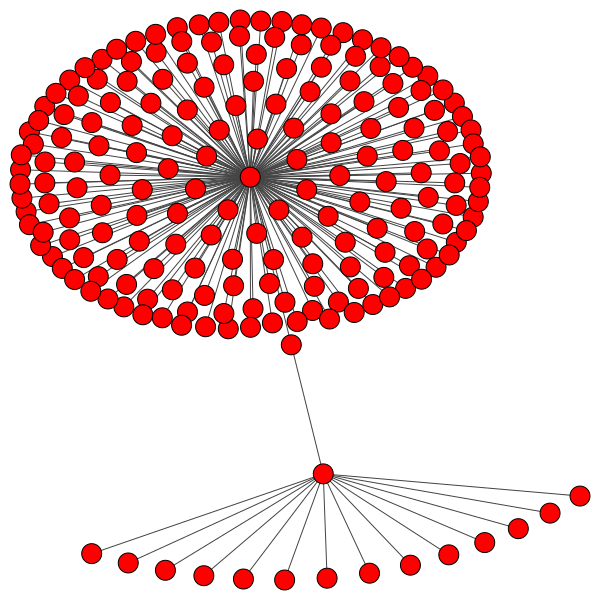

In [17]:
layout = graph2.layout("kk")
plot(graph2,layout=layout)

0.29003428356055594

In [448]:
a = graph.vs.select(membership_eq=comm, name_eq='/user_details?userid=v8cFU4eJKgVgGYCyovE3kQ')

In [470]:
a = graph.vs.select(lambda vertex: vertex.index not in [0,1,2])

In [471]:
[i.index for i in a]

[3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,


In [482]:
a = graph.community_fastgreedy()

In [486]:
a1 = a.as_clustering()

In [489]:
graph.vs['membership'] = a1.membership

In [522]:
graph.es['rating'][0]

4.0

In [525]:
a = np.array([np.nan, np.nan, 5, 1])

In [526]:
a

array([ nan,  nan,   5.,   1.])

In [527]:
np.nanmean(a)

3.0

In [528]:
np.sum(([] - []) ** 2)

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [529]:
a = np.array([0,0,0])
b = np.array([0,0,0])

In [530]:
c = a[a!=0]
d = b[a!=0]

In [533]:
mse2 = np.array([0,0,0,0,0])

In [540]:
len(mse2[mse2!=0])

0

In [535]:
np.mean(mse2[mse2!=0])

nan

In [542]:
np.nanmean(4)

4.0

In [545]:
np.array([0]) * np.arange(0,1315)

array([0, 0, 0, ..., 0, 0, 0])

In [550]:
np.array([]) * np.arange(0,1315)

ValueError: operands could not be broadcast together with shapes (0,) (1315,) 

In [552]:
def rescale_value(value):
        OldMax = 1.0
        OldMin = -1.0
        NewMax = 1.0
        NewMin = 0.0
        OldRange = (OldMax - OldMin)
        NewRange = (NewMax - NewMin)
        NewValue = (((value - OldMin) * NewRange) / OldRange) + NewMin
        return NewValue

In [564]:
graph.vs.attribute_names()

['membership', 'name', 'cruisine']

In [565]:
graph.modularity(graph`.vs['membership'])

0.3068233477804441

In [786]:
x = Graph()
type(x)

igraph.Graph

In [787]:
x.add_vertex(name='allen') # in community
x.add_vertex(name='joe') # DELETE
x.add_vertex(name='hans') # in community
x.add_vertex(name='mike') # in community
x.add_vertex(name='business') # business
x.vs['age'] = [234,345,1,42,3,234]
x.vs['height'] = []
x.add_edges([(0,1), (1,2)])

ValueError: sequence must not be empty

In [780]:
sel = x.vs.select(lambda vertex: vertex.index not in [0,2,3] and vertex.index != 4)

In [781]:
[i.index for i in sel]

[1]

In [782]:
x2 = x.copy()
x2.delete_vertices([i.index for i in sel])

In [785]:
x2.vs['hi']

[234, 1, 42, 3]

In [788]:
users = pickle.load(open("../data/extra/users.p", 'rb'  ))
businesses = pickle.load(open("../data/extra/businesses.p", 'rb'  ))

In [792]:
graph.summary()

'IGRAPH UN-- 17756 108399 -- \n+ attr: cruisine (v), membership (v), name (v), name (e), rating (e), review_id (e)'

In [26]:
dict_all_users_of_a_business = pickle.load(open("../data/dict_all_users_of_a_business.p", 'rb'  ))
dict_all_businesses_of_a_user = pickle.load(open("../data/dict_all_businesses_of_a_user.p", 'rb'  ))

In [35]:
a = dict_all_businesses_of_a_user[u'/user_details?userid=5APTqkWxEPTcYEY6PfFjrw']

In [36]:
a

{u'bella-trattoria-san-francisco',
 u'chabaa-thai-cuisine-san-francisco-2',
 u'dotties-true-blue-cafe-san-francisco'}

In [59]:
sel = g.vs.select(business_id_in=a)

In [61]:
[i for i in sel]

[igraph.Vertex(<igraph.Graph object at 0x121020718>,0,{'business_id': u'bella-trattoria-san-francisco'}),
 igraph.Vertex(<igraph.Graph object at 0x121020718>,1,{'business_id': u'chabaa-thai-cuisine-san-francisco-2'}),
 igraph.Vertex(<igraph.Graph object at 0x121020718>,2,{'business_id': u'dotties-true-blue-cafe-san-francisco'})]

In [163]:
g = Graph()
g.add_vertex()
g.add_vertex()
g.add_vertex()
g.add_vertex()
g.add_vertex()
g.add_vertex()
g.add_vertex()

In [181]:
g.vs['business_id'] = [u'bella-trattoria-san-francisco',u'bella-trattoria-san-francisco',u'bella-trattoria-san-francisco',u'chabaa-thai-cuisine-san-francisco-2',u'chabaa-thai-cuisine-san-francisco-2',u'dotties-true-blue-cafe-san-francisco','test']
g.vs['rating'] = [1,5,3]

In [182]:
g.vs['business_id']

[u'bella-trattoria-san-francisco',
 u'bella-trattoria-san-francisco',
 u'bella-trattoria-san-francisco',
 u'chabaa-thai-cuisine-san-francisco-2',
 u'chabaa-thai-cuisine-san-francisco-2',
 u'dotties-true-blue-cafe-san-francisco',
 'test']

In [186]:
[i for i in g.vs.select(business_id_in={u'bella-trattoria-san-francisco'})]

[igraph.Vertex(<igraph.Graph object at 0x121020908>,0,{'rating': 1, 'business_id': u'bella-trattoria-san-francisco'}),
 igraph.Vertex(<igraph.Graph object at 0x121020908>,1,{'rating': 5, 'business_id': u'bella-trattoria-san-francisco'}),
 igraph.Vertex(<igraph.Graph object at 0x121020908>,2,{'rating': 3, 'business_id': u'bella-trattoria-san-francisco'})]

In [192]:
list(0)

TypeError: 'int' object is not iterable

In [169]:
g.vs['rating']

[1, 5, 3, 1, 5, 3, 1]

In [82]:
[i for i in g.vs[0,1,2]['business_id']]

[u'bella-trattoria-san-francisco',
 u'bella-trattoria-san-francisco',
 u'chabaa-thai-cuisine-san-francisco-2']

In [84]:
x = [i for i in g.vs[[0,1,3]]['business_id']]

In [113]:
Counter(g.vs['business_id']).most_common()

[(u'bella-trattoria-san-francisco', 3),
 (u'chabaa-thai-cuisine-san-francisco-2', 2),
 (u'dotties-true-blue-cafe-san-francisco', 1),
 ('test', 1)]

In [132]:
nofind = 5

In [133]:
list(reversed(Counter(g.vs['business_id']).most_common()))[0:nofind]

[(u'chabaa-thai-cuisine-san-francisco-2', 1),
 ('test', 1),
 (u'dotties-true-blue-cafe-san-francisco', 1)]

In [130]:
g.delete_vertices([0,0,0,0,0,0,0])

In [198]:
graph.vs.attribute_names()

['membership', 'name', 'cruisine']

In [244]:
graph.es.attribute_names()

['rating', 'name', 'review_id']

In [243]:
graph.summary()

'IGRAPH UN-- 17756 108399 -- \n+ attr: cruisine (v), membership (v), name (v), name (e), rating (e), review_id (e)'

In [254]:
a.append(graph.vs[0]['cruisine'])

In [253]:
a=[12,2]

In [259]:
a = graph.vs[0:5]

In [260]:
a.closeness()

[0.2636385234460844,
 0.3394967302764924,
 0.26865694225880643,
 0.26674378774676244,
 0.29695601271115574]

# Stuff

In [ ]:
mongoexport --db yelp --collection yelp_500_plus --type=csv --fields id,name,review_count,rating,categories,location --query '{"type":"business", "review_count": {$gte: 500 }}' --out yelp_businesses.csv

In [416]:
yelp = pd.read_csv("../data/yelp_businesses.csv")

In [417]:
yelp['latitude'] = yelp['location'].map(lambda x: json.loads(x)['coordinate']['latitude'])
yelp['longitude'] = yelp['location'].map(lambda x: json.loads(x)['coordinate']['longitude'])

In [418]:
yelp.drop(['location'], axis=1, inplace=True)

In [419]:
yelp.to_csv("../data/yelp_businesses.csv")

In [436]:
a = set((1,2,3,4))

In [437]:
a

{1, 2, 3, 4}

In [439]:
if 0 in a:
    a.remove(0)

In [440]:
a

{1, 2, 3, 4}